# Unsupervised Anomaly detection on Spotify data 🎵 : K-Means vs Local Outlier Factor

En esta _notebook_ se documenta la aplicación de los algoritmos de detección de anomalías del post de 
Medium [Unsupervised Anomaly detection on Spotify data: K-Means vs Local Outlier Factor]()

> This notebook shows how the anomaly detection anomlies applied in the Medium post 
> [Unsupervised Anomaly detection on Spotify data: K-Means vs Local Outlier Factor]()

# Import relevant libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import datapane as dp

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Unsupervised (Machine) Learning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor

# Metrics (distance) and stats
from scipy.spatial.distance import euclidean
from scipy.stats import median_abs_deviation

# Visualize in a two-dimensional space
from sklearn.decomposition import PCA


# Setting up the font family
# -> Matplotlib + Seaborn
plt.rcParams['font.family'] = 'Georgia'
# -> Altair
FontFam = 'Georgia'

# Ignore warnings (only for presentation)
import warnings
warnings.filterwarnings('ignore')


# Load the data

In [2]:
# Change duration from ms to min
def convert_miliseconds(miliseconds, conversion = 'minutes'):
    if conversion == 'minutes':
        return miliseconds / 60000
    elif conversion == 'seconds':
        return miliseconds / 1000

In [3]:
# Rene Perez Joglar a.k.a Residente was the vocalist and 
# songwriter of Calle 13. In this project I consider both 
# artists the same person.
def find_residente_calle13(artist):
    condition_1 = artist == 'Calle 13'
    condition_2 = artist == 'Residente'
    if condition_1 or condition_2:
        return 'Residente/Calle 13'
    else: 
        return artist

In [4]:
df = pd.read_csv('../data/songs_atributtes_my_top_100_2016-2021.csv')

# integers --> categorical 
cat_key = pd.CategoricalDtype(categories=[-1,0,1,2,3,4,5,6,7,8,9,10,11], ordered= True)
cat_time_signature = pd.CategoricalDtype(categories=[1,2,3,4,5,6,7], ordered= True)

df['key'] = df['key'].astype(cat_key)
df['time_signature'] = df['time_signature'].astype(cat_time_signature)
df['mode'] = df['mode'].astype('category')

# Apply initial functions
df['artist'] = df['artist'].apply(find_residente_calle13)
df['duration_minutes'] = df['duration_ms'].apply(convert_miliseconds, args = ('minutes',))
df = df.drop(columns='duration_ms')

# Remove duplicated songs + artists
# For example: Growing Pains is duplicated and the artist is Alessia Cara (in both songs)
df = df.drop_duplicates(subset=['name', 'artist'], keep='first')
df = df.reset_index(drop=True)

print(f'This dataset has {df.shape[1]} attributes and {df.shape[0]} instances')

This dataset has 18 attributes and 504 instances


In [5]:
df.head()

,name,artist,album,URI,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_popularity,duration_minutes
0,On My Wave,Keiynan Lonsdale,Rainbow Boy,01iaXaqUjZVsdLp2yF3OQ9,0.486,0.773,6,-4.199,1,0.2450,0.1320,0.000007,0.0840,0.439,120.145,4,44,4.117700
1,"96,000",Anthony Ramos,In The Heights (Original Motion Picture Soundt...,0CpE5SeQkHQPYiWX0psxf4,0.479,0.614,7,-7.001,1,0.3360,0.0130,0.000000,0.1620,0.406,171.930,4,72,5.764517
2,Pessimist,Greta Isaac,Pessimist,0IkBQt9vSLLwoX0knkusSl,0.539,0.524,4,-8.279,1,0.2360,0.0473,0.000349,0.0806,0.729,174.047,3,39,3.200450
3,Girl Next Door,Alessia Cara,The Pains Of Growing,0JjJGeUbFqCRe4nKNVCAz9,0.705,0.516,0,-5.770,1,0.1200,0.5830,0.000000,0.0780,0.422,115.740,4,81,3.376667
4,Somebody Else,Alessia Cara,In The Meantime,0O9ijXvoYpXDjqhaYZtA2X,0.718,0.721,4,-5.525,1,0.0429,0.0190,0.000000,0.1440,0.963,108.070,4,81,3.576900


# Data catalog

> The data catalog can be found [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

| Nombre                 | Descripción                                                                                                                                                                                                         | Rango y tipo de dato   |
|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| **`acousticness`**     | Es el **nivel de confianza** de que la canción sea **acústica**                                                                                                                                                     | [0, 1] (_`float`_)     |
| **`danceability`**     | Indica que tan _**bailable**_ es una canción basándose en diferentes elementos musicales como tempo, ritmo, _beat_, entre otros.                                                                                    | [0,1] (_`float`_)      |
| **`duration_ms`**      | El tiempo de duración de la canción en milisegundos, sin embargo esta luego se modifica a **`duration_minutes`**.                                                                                                   | _`float`_              |
| **`energy`**           | Valores altos de **energía** representan canciones rápidas, activas y ruidosas, de lo contrario la energía es baja. Toma en cuenta aspectos como rango dinámico, timbre, volumen percibido, entre otros.            | [0, 1] (_`float`_)     |
| **`instrumentalness`** | Predice **si la canción no contiene vocales**. Entre más **instrumental** sea la canción, más alto el valor de este atributo. Canciones del género de rap tienen un bajo valor.                                     | [0,1] (_`float`_)      |
| **`liveness`**         | Este valor indica la presencia de audiencia. Entre más audiencia detecta, más alto su valor y mayor probabilidad es de que la canción haya sido **en vivo**                                                         | [0,1] (_`float`_)      |
| **`loudness`**         | La presencia de **riudo en decibeles (dB)**, la amplitud de las ondas de la canción. Este valor es el promedio de la canción.                                                                                       | [-60,0] (_`float`_)    |
| **`speechiness`**      | Detecta la **presencia de palabras**. Muy altos niveles indican audiolibros, podcasts, entre otros; altos niveles pueden ser canciones del género rap, valores bajos indican poco aporte de palabras en la canción. | [0,1] (_`float`_)      |
| **`tempo`**            | Los **_Beats Per Minute_ (BPM)**, la velocidad o el paso de una canción.                                                                                                                                            | (_`float`_)            |
| **`valence`**          | Describe la **positividad** de la canción. Valores altos indican mayor positividad (alegría, euforia, ánimos) y valores bajos indican más negatividad (tristeza, depresión, enojo).                                 | [0,1] (_`float`_)      |
| **`key`**              | Clasifica el _**pitch**_ o las **notas** de la canción. Canciones con bajo _pitch_ suenan más graves, mientras que con alto _pitch_ suenan más agudos. Cuando no se conoce el valor se marca **-1**.                | [-1,11] (_`category`_) |
| **`time_signature`**   | La notación convencional que indica cuantos _beats_ hay en cada _bar_. Se escriben únicamente los numeradores, ya que el denominador es 4. Por ejemplo, "**4**/4" o "**7**/4"                                       | [1,7] (_`category`_)   |
| **`mode`**             | Indica la **modalidad** (mayor o menor) de una canción, el tipo de escala del que se deriva su contenido melódico. La mayor se representa con 1 y la menor con 0.                                                   | 0 y 1 (_`category`_)   |


# Choosing the features

>The anomaly detection algorithms are going to be applied in N groups of no more than three features. By doing so, the data points are not very sparse (more dimensions = more space between data points). Local Outlier Factor (LOF) and K-Means are density-based and distance algorithms, respectively.
>
>
>The first step is filtering under some criteria, for example, selecting a pair or third based on their correlation or personal choice/interest.

Los algoritmos de detección de anomalías serán aplicados en **N** grupos de **máximo tres 
variables**. Esto se hace para que los datos no estén tan dispersos, ya que a mayor número de dimensiones, 
menor es la densidad entre los puntos. **LOF** y **K-Means** son algoritmos basados en distance y densidad,
respectivamente.

Se cuentan con 11 variables, lo que significa que existen 55 pares de variables con las que se pueden experimentar

No todos todos las combinaciones se hará, como primer paso se filtrarán. Alguna de las maneras en las que 
se puede hacer esta tarea. Por ejemplo: través de un rango o límite en la correlación entre dos o tres 
variables o elección personal sobre cuales variables se consideraría interesante explorar para encontrar 
anomalías.

## Low Correlation

> Filtering by correlation could show how much information is dispersed in each pair of variables. For this task, a **correlation index magnitude bigger than 0.6 is a high correlation**, and **less than 0.15 is considered a low correlation.**
>
> In this project, I am going to focus on variables with the **lowest correlation.**
>
> Why am I interested in low correlation scores? Well, data with correlations closer to 0 can have different shapes. For example, some of them are shown in the image below.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/800px-Correlation_examples2.svg.png" width=700px></img>

In [6]:
# Low correlation variables
df_low_corr = df.corr()

maskLow_lower_02 = df_low_corr < 0.15
maskLow_bigger_02 = df_low_corr > - 0.15
mask_low_corr = ( maskLow_lower_02 & maskLow_bigger_02 )

# Show the table
df_low_corr = df_low_corr[(mask_low_corr)]
df_low_corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_popularity,duration_minutes
danceability,nan,0.127612,nan,0.075420,nan,nan,-0.048589,nan,nan,0.038105,nan
energy,0.127612,nan,nan,-0.040563,nan,nan,nan,nan,0.048875,0.060131,-0.001182
loudness,nan,nan,nan,-0.108657,nan,nan,nan,nan,0.048199,nan,-0.072898
speechiness,0.075420,-0.040563,-0.108657,nan,0.031802,-0.092995,0.068295,nan,nan,-0.083269,-0.027039
acousticness,nan,nan,nan,0.031802,nan,nan,nan,nan,-0.092962,-0.073937,0.019949
instrumentalness,nan,nan,nan,-0.092995,nan,nan,-0.062551,nan,-0.068367,nan,0.009066
liveness,-0.048589,nan,nan,0.068295,nan,-0.062551,nan,0.082365,0.040090,-0.032819,-0.069929
valence,nan,nan,nan,nan,nan,nan,0.082365,nan,-0.044667,-0.041914,nan
tempo,nan,0.048875,0.048199,nan,-0.092962,-0.068367,0.040090,-0.044667,nan,0.014586,0.076299
artist_popularity,0.038105,0.060131,nan,-0.083269,-0.073937,nan,-0.032819,-0.041914,0.014586,nan,-0.000628


Text(0.5, 0.91, 'Lower correlated variables')

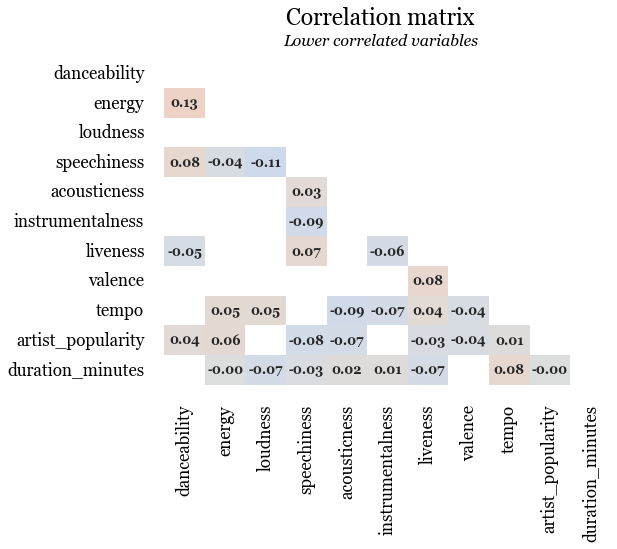

In [7]:
mask = np.zeros_like(df_low_corr.values)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,6),
                       #dpi = 150
                      )

sns.heatmap(data=df_low_corr, cmap='coolwarm', square= False, mask=mask,
            vmin = -1, vmax = 1, center = 0,
            cbar = False, 
            annot = True, fmt = '.2f',
            annot_kws = {'size':13, 'fontweight':'bold'},
           )
ax.tick_params(axis='both', length = 0)
ax.tick_params(axis='both', rotation = 0, pad = 20, labelsize = 17)
ax.tick_params(axis='x', rotation=90)
fig.suptitle('Correlation matrix', y = 1.0, size = 23)
fig.text(x=0.5, y=0.91, s="Lower correlated variables", ha = 'center',
         fontdict = {'fontstyle':'italic', 'size': 16})

> We can see that all the variables have a low correlation with each other. This amount of features 
> means that we can find different patterns across them.  

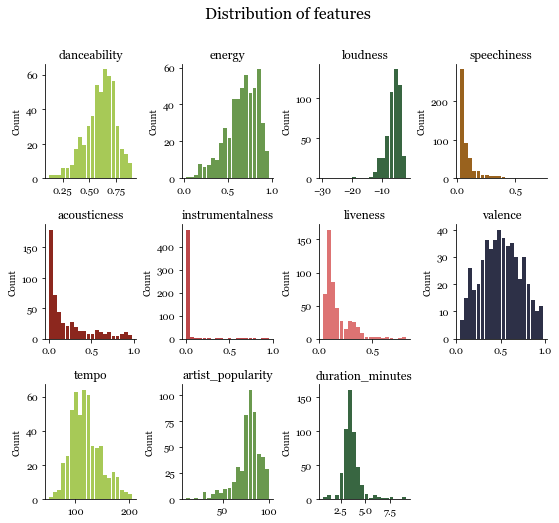

In [8]:
lowCorr_vars = df_low_corr.columns.to_list()
colours = ['#a7c957', '#6a994e','#386641', '#99621e','#8c271e', '#bc4749',
           '#dd7373', '#2d3047',] * 2

fig = plt.figure(figsize=(9,8),
                 #dpi = 150,
                 facecolor='white')
fig.suptitle('Distribution of features', size = 16)
fig.subplots_adjust(wspace=0.5, hspace=0.4)

for i in range(len(lowCorr_vars)):
    plt.subplot(3,4,i+1)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.hist(x=df[lowCorr_vars[i]], bins=20, rwidth=0.9, color = colours[i])
    ax.set_title(f'{lowCorr_vars[i]}', size= 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Count')

> **An observation:** The variable `'instrumentalness'` is strongly biased to the left (long tail in the right). This means that most songs are close to zero ➡️ songs that are mostly vocal with low instrumental content.

Algo interesente que se puede obsevar en los histogramas es que `'instrumentalness'` esta fuertemente 
sesgada a la derecha. Esto significa que la gran mayoría de las instancias están cercanas al **0**, 
es decir, instancias con alto contenido vocal y muy poco contenido únicamente instrumental.


## Personal choice: Where would be interesting to find anomalies? 

> Some questions have arisen, and those questions are represented in the form of pairs of features:
>
> * **`valence`** and **`artist_popularity`:** valence describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry) [4]. What could be an anomaly?:
>
>     * A song from a famous artist that is more positive or more negative?
>     * A song from a non-popular artist that is more positive or more negative?
> 
> 
> * **`tempo`** and **`duration_minutes`:** `tempo` is the speed or pace of a given piece and derives directly from the average beat duration measured in BPM (Beats Per Minute) [4]. People have always wanted to classify almost everything throughout time, and music is not the exception. One way (because there are other ways )of doing it is listening to the tempo. For example, Reggae has a typical BPM ranging from 60 - 90, Hip-Hop between 85 - 115 BPM and Pop between 100 - 130. I don't attempt to classify the songs I listened to but identify the ones with expected time duration from the anomalies; think about most pop songs last on average 3.5 minutes (210 seconds). How many of them fall into this assumption? What about the ones who do not?  
> For more information about music genres and tempo, visit [_Music Genres And Their Typical BPMs_](https://www.gemtracks.com/guides/view.php?title=music-genres-and-their-typical-bpms&id=823#classification-of-genre)
and for time duration of songs visit [_A hit song is usually 3 to 5 minutes long. Here's why._](https://www.vox.com/2014/8/18/6003271/why-are-songs-3-minutes-long)
>
> * **`danceability`** and **`energy`:** How many songs suitable for dancing (high `danceability`) do not have high energy (low values of `energy`)? It seems contradictory since people associate dancing with energy most of the time, but in this contradiction, interesting anomalies are yet to be found.

# Anomaly detection

> There're three different scenarios with their respective features to analyze

In [9]:
vars_01 = ['valence','artist_popularity']
vars_02 = ['tempo','duration_minutes']
vars_03 = ['danceability','energy']

## `'valence'` and `'artist_popularity'`

### Data pre-processing

In [10]:
df_01 = df[ ['URI'] + vars_01]

# Pre processing -> range from 0 to 1 -> popularity
df_01['artist_popularity'] = df_01['artist_popularity']/100

X_01 = df_01[vars_01].values

### K-Means

> **1. Find the optimal number of clusters:** The techniques used are the **Elbow Method** and using the 
**Silhouette score** [5]

In [11]:
# Find the ideal number of clusters 
def find_optimal_k_clusters_plot(dataframe, features_name, minK, maxK, titlePlot, random_state = 11):
    """
    This function displays a plot of the Within Cluster Sum Squares (WCSS) and the 
    Silhouette Score. The objective of this function is to visually identify the 
    optimal number of clusters
    
    * **`dataframe`** (_pandas.DataFrame_): The dataframe previously processed
    * **`features_names`** (_array like_): A list or ndarray with the name of the columns/features to be used.
    * **`minK`** and **`maxK`** (_int_): are the minimun (inclusive) and maximum (non inclusive)
    amount of clusters to test.
    * **`random_state`** (_default = 11_): Is a random seed for reproducibility 
    """
    X = dataframe[features_name].values
    wcss = []
    list_models = []

    for i in range(minK, maxK):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_state)
        kmeans.fit(X)
        list_models.append(kmeans)
        wcss.append(kmeans.inertia_)
    
    sil_scores = [silhouette_score(X, model.labels_, random_state=random_state) 
                  for model in list_models[1:]]
    
    # P L O T   R E S U L T S
    fig, ax1 = plt.subplots(figsize = (6,4.5), dpi=100, facecolor='white')
    ax1.set_facecolor('white')
    fig.suptitle(titlePlot, size=13)
    ax1.plot(range(minK, maxK), wcss,
             linestyle = '--', marker = 'P', color = 'teal', label = 'WCSS')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS')
    ax1.tick_params(axis = 'y', colors = 'teal')
    ax1.yaxis.label.set_color('teal')
    
    ax2 = ax1.twinx()
    ax2.plot(range(minK + 1, maxK), sil_scores,
             linestyle = ':', marker = 'o', color = 'maroon', label = 'Silhouette score')
    ax2.set_ylabel('Silhouette Score')
    ax2.tick_params(axis = 'y', colors = 'maroon')
    ax2.yaxis.label.set_color('maroon')

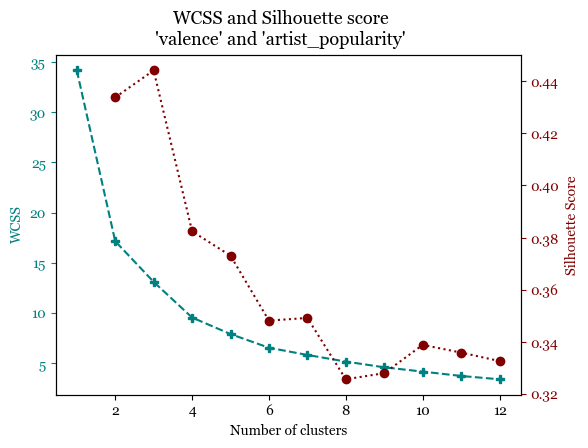

In [12]:
# Test from 1 to 12 clusters 
find_optimal_k_clusters_plot(dataframe = df_01,
                             features_name = vars_01,
                             minK = 1, maxK= 13, titlePlot="WCSS and Silhouette score\n'valence' and 'artist_popularity'")

> The optimal number of clusters is **3**

***

> **2. Once the number of clusters is defined, apply the algorithm and label the observations**

In [13]:
# Create model of k clusters and train it
kmeans_01 = KMeans(n_clusters=3, init='k-means++', random_state=11)
kmeans_01.fit(X_01)

# Get labels and clusters
arr_labels_01 = kmeans_01.predict(X_01).reshape((-1,1))
arr_centroids_01 = kmeans_01.cluster_centers_

# Label the data with the predictions in the data frame
df_01['clusters'] = arr_labels_01.flatten()

# Create array of features and labels
arr_features_labels_01 = df_01[vars_01 + ['clusters']].values

df_01.head()

,URI,valence,artist_popularity,clusters
0,01iaXaqUjZVsdLp2yF3OQ9,0.439,0.44,2
1,0CpE5SeQkHQPYiWX0psxf4,0.406,0.72,1
2,0IkBQt9vSLLwoX0knkusSl,0.729,0.39,2
3,0JjJGeUbFqCRe4nKNVCAz9,0.422,0.81,1
4,0O9ijXvoYpXDjqhaYZtA2X,0.963,0.81,0


***

> **3. Find the distance from each vector/point to their respective centroid's cluster**

In [14]:
# Get distance to centroid
def get_distance_centroid(array, centroids):
    """
    This function is made to be used with `numpy.apply_along_axis`.Takes in an n-dimensional 
    vector of features (previously processed) and finds the distance to their respective 
    cluster centroid.
    
    * **`array`**: 
    * **`centroids`**:
    """
    vector = array[:-1]
    label = array[-1]
    centroid = centroids[int(label)]
    dist = euclidean(vector, centroid)
    return dist

In [15]:
# Find distance
arr_distances_centroid_01 = np.apply_along_axis(func1d = get_distance_centroid, axis=1,
                                                arr= arr_features_labels_01,
                                                centroids = arr_centroids_01)
# Add data to data frame
df_01['distance_centroid'] = arr_distances_centroid_01

df_01.head()

,URI,valence,artist_popularity,clusters,distance_centroid
0,01iaXaqUjZVsdLp2yF3OQ9,0.439,0.44,2,0.046732
1,0CpE5SeQkHQPYiWX0psxf4,0.406,0.72,1,0.128879
2,0IkBQt9vSLLwoX0knkusSl,0.729,0.39,2,0.253411
3,0JjJGeUbFqCRe4nKNVCAz9,0.422,0.81,1,0.102713
4,0O9ijXvoYpXDjqhaYZtA2X,0.963,0.81,0,0.272904


***

> **4. Get the [Modified Z-score](https://medium.com/analytics-vidhya/anomaly-detection-by-modified-z-score-f8ad6be62bac) 
from `distance_centroid` distribution**: When dealing with anomalies is better to use the Modified Z-score 
(Equation 1) instead of the common Z-score (Equation 2):
> 
> $$\text{Z}_{\text{mod}} = \frac{x_{i} - \widetilde{x}}{\text{MAD}} \tag{1}$$
> 
> $$\text{Z}_{\text{score}} = \frac{x_{i} - \overline{x}}{\sigma} \tag{2}$$
> 
> Where $\widetilde{x}$ is **the median of $X$ and $\text{MAD}$ is the Median Absolute Deviation 
from the Median**:
>
> $$\text{MAD} = \text{median}\left( \left|\, x_{i} - \widetilde{x}\, \right| \right)$$



In [16]:
# Get distance to centroid (Standardised)
def calculate_modifed_z_score(array, medians, mads):
    """
    This function is made to be used with `numpy.apply_along_axis`. Takes in a 2-dimensional 
    vector of distances and labels and returns their respective Modified Z-score acording to 
    their respective distribution.
    
    * **`array`** (_ndarray_): A vector/array of 2 dimensions where the first element is the 
                               distance to the cluster's centroidlast element and the second 
                               element the label of the category/group/cluster.
                               The label must be in a numeric form starting from 0 up to the 
                               _n-1_ category.
                               The labels must match with the index of their respective elment 
                               in `medians`.
    * **`medians`** (_array like_): A list or ndarray containig the medians of the respective 
                                    distance distribution from each category
    * **`mads`** (_array like_): A list or ndarray contaiing the median absolute deviation from 
                                 the median of the respective distance distribution from each 
                                 category
    """
    distance, label = array
    median = medians[int(label)]
    mad = mads[int(label)]
    z_mod = (distance - median)/mad
    return z_mod

In [17]:
arr_distances_labels_01 = df_01[['distance_centroid','clusters']].values

In [18]:
median_01_0 = np.median(df_01.query("clusters == 0")['distance_centroid'].values)
median_01_1 = np.median(df_01.query("clusters == 1")['distance_centroid'].values)
median_01_2 = np.median(df_01.query("clusters == 1")['distance_centroid'].values)
list_medians_01 = [median_01_0, median_01_1, median_01_2]

mads_01_0 = median_abs_deviation(df_01.query("clusters == 0")['distance_centroid'].values)
mads_01_1 = median_abs_deviation(df_01.query("clusters == 1")['distance_centroid'].values)
mads_01_2 = median_abs_deviation(df_01.query("clusters == 0")['distance_centroid'].values)
list_mads_01 = [mads_01_0, mads_01_1, mads_01_2]

In [19]:
arr_z_mod_01 = np.apply_along_axis(func1d= calculate_modifed_z_score,
                                   arr= arr_distances_labels_01,
                                   axis = 1,
                                   medians = list_medians_01,
                                   mads = list_mads_01
                                  )

In [20]:
df_01['z_mod'] = arr_z_mod_01
df_01.head()

,URI,valence,artist_popularity,clusters,distance_centroid,z_mod
0,01iaXaqUjZVsdLp2yF3OQ9,0.439,0.44,2,0.046732,-1.935190
1,0CpE5SeQkHQPYiWX0psxf4,0.406,0.72,1,0.128879,-0.174508
2,0IkBQt9vSLLwoX0knkusSl,0.729,0.39,2,0.253411,2.516561
3,0JjJGeUbFqCRe4nKNVCAz9,0.422,0.81,1,0.102713,-0.767772
4,0O9ijXvoYpXDjqhaYZtA2X,0.963,0.81,0,0.272904,2.892730


***

> This process can be encapsulated in a function ➡️ **`characterization_k_clusters`**

In [21]:
def characterization_k_clusters(dataframe, features_name, K, random_state = 11):
    """
    """
    X = dataframe[features_name].values
    
    # 1. Create model and label the instances
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=random_state)
    kmeans.fit(X)
    arr_labels = kmeans.predict(X).reshape((-1,1))
    arr_centroids = kmeans.cluster_centers_
    dataframe['clusters'] = arr_labels.flatten()
    
    # 2. Create an array of features and lables 
    arr_features_and_labels = dataframe[ features_name + ['clusters'] ].values
    
    # 3. Find the distance between the centroid and its respective vectors
    arr_distance_between_centroid_vectors = np.apply_along_axis(func1d = get_distance_centroid,arr = arr_features_and_labels,
                                                                axis = 1, centroids = arr_centroids)
    dataframe['distance_centroid'] = arr_distance_between_centroid_vectors
    
    # 4. Ge the modified Z-score of each distance_centroid observation
    arr_distance_and_labels = dataframe[['distance_centroid', 'clusters']].values
    # -> Iterate over the labes and get the median and MAD
    arr_labels_iterations = np.sort( dataframe['clusters'].unique() )
    list_medians = []
    list_mads = []
    for label in arr_labels_iterations:
        arr_distance_specific_cluster = dataframe.query(f"clusters == {label}")['distance_centroid'].values
        median_distance_specific_cluster = np.median( arr_distance_specific_cluster )
        mad_distance_specific_cluster = median_abs_deviation( arr_distance_specific_cluster )
        list_medians.append( median_distance_specific_cluster )
        list_mads.append( mad_distance_specific_cluster )
    # -> Calculate the Modified Z-score
    arr_z_mod = np.apply_along_axis(func1d= calculate_modifed_z_score, arr = arr_distance_and_labels, axis = 1,
                                    medians = list_medians, mads = list_mads)
    dataframe['z_mod'] = arr_z_mod
    return dataframe

### LOF

In [22]:
# Matrix of features
X_01 = df_01[vars_01].values

> **1. Create the model and specify the number of _K_ neightbours. _In this case and all the rest of the models K = 20_**

In [23]:
# Create model
lof_01 = LocalOutlierFactor(n_neighbors=20)

> **2. Train the model**

In [24]:
# Train 
lof_01.fit(X_01)

LocalOutlierFactor()

> **3. Get the Local Outlier Factor (score)**

In [25]:
# Get LOF score
negative_lof = lof_01.negative_outlier_factor_

# Label data with the score (the closer to one -> inlier. Bigger than one -> outlier
df_01['local_outlier_factor'] = negative_lof * -1

In [26]:
df_01.head()

,URI,valence,artist_popularity,clusters,distance_centroid,z_mod,local_outlier_factor
0,01iaXaqUjZVsdLp2yF3OQ9,0.439,0.44,2,0.046732,-1.935190,1.151659
1,0CpE5SeQkHQPYiWX0psxf4,0.406,0.72,1,0.128879,-0.174508,1.095789
2,0IkBQt9vSLLwoX0knkusSl,0.729,0.39,2,0.253411,2.516561,1.248131
3,0JjJGeUbFqCRe4nKNVCAz9,0.422,0.81,1,0.102713,-0.767772,0.982497
4,0O9ijXvoYpXDjqhaYZtA2X,0.963,0.81,0,0.272904,2.892730,1.106624


> This process can be encapsulated in a function ➡️ **`get_local_outlier_factor_scores`**

In [27]:
def get_local_outlier_factor_scores(dataframe, features_name, k_neighbours = 20):
    """
    """
    X = dataframe[features_name].values
    # 1. Create model
    lof_model = LocalOutlierFactor(n_neighbors= k_neighbours)
    # 2. Train the model
    lof_model.fit(X)
    # 3. Get the Local Outlier Factor (score)
    negative_lof = lof_model.negative_outlier_factor_
    dataframe['local_outlier_factor'] = -1 * negative_lof
    return dataframe

## `'tempo'` and `'duration_minutes'`

### Data pre-processing

In [28]:
df_02 = df[ ['URI'] + vars_02]

# Pre processing -> StandardScaler
df_02[['tempo_scaled','duration_minutes_scaled']] = StandardScaler().fit_transform(df_02[vars_02])

# Update vars_02
vars_02 = ['tempo_scaled','duration_minutes_scaled']

### K-Means

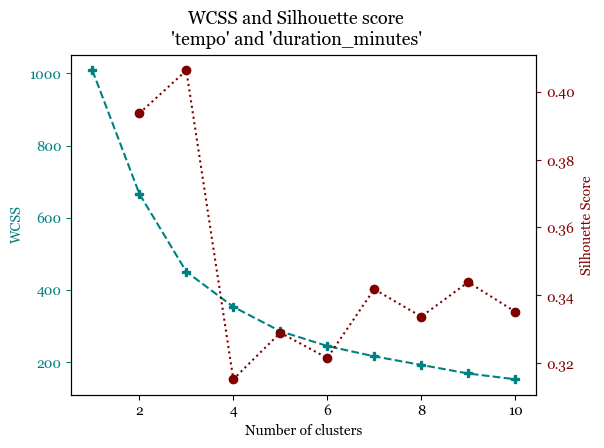

In [29]:
find_optimal_k_clusters_plot(dataframe=df_02, features_name=vars_02, minK=1, maxK=11,
                            titlePlot="WCSS and Silhouette score\n'tempo' and 'duration_minutes'")

> The optimal number of clusters is **3**

In [30]:
df_02 = characterization_k_clusters(dataframe=df_02, features_name= vars_02, K= 3)

### LOF

In [31]:
df_02 = get_local_outlier_factor_scores(dataframe= df_02, features_name= vars_02)

## `'danceability'` and `'energy'`

### Data pre-processing

In [32]:
df_03 = df[ ['URI'] + vars_03 ]

### K-Means

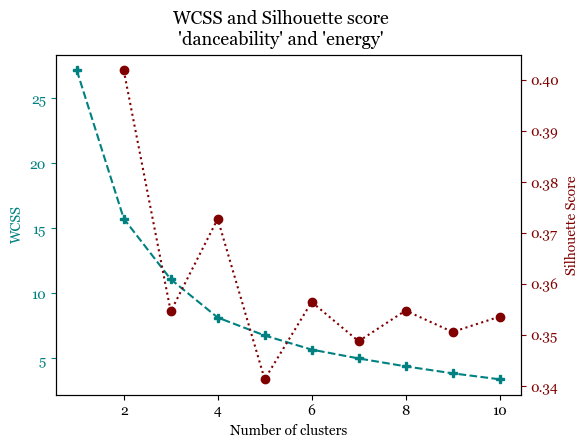

In [33]:
find_optimal_k_clusters_plot(dataframe=df_03, features_name= vars_03, minK=1, maxK=11,
titlePlot="WCSS and Silhouette score\n'danceability' and 'energy'")

> The optimal number of clusters is **2**

In [34]:
df_03 = characterization_k_clusters(dataframe=df_03, features_name= vars_03, K = 2)

### LOF

In [35]:
df_03 = get_local_outlier_factor_scores(dataframe=df_03, features_name= vars_03)

# Results and Discussion

> **How will anomalies be identified?**
>
> In order to indentify the anomalies a threshold must be given to each metric:
> 
> * **K-Means:** A $z_{\text{mod}} > 3 \Rightarrow$ **outlier** (values far away from the median)
> * **Local Outlier Factor (LOF):** A score $> 1.25$
>
> **Which songs are anomalies/outliers?**
>
>
> In the case of LOF, we just need to look at the score. However, a different perspective must be taken for the case of the K-Means algorithm.
The $z_{\text{mod}}$ of each instance is according to their respective cluster centroid, so the anomalies are also according to the assigned cluster. So it's crucial to keep that in mind during the analysis and interpretation.

In [36]:
def detect_anomaly(value, threshold, detector):
    if detector == 'z_mod':
        if value > threshold:
            return 'Outlier'
        else: 
            return 'Inlier'
    elif detector == 'lof':
        if value > threshold:
            return 'Outlier'
        else: 
            return 'Inlier'

In [37]:
# Variables to complement the final data frame of each scenario
vars_songs_info = ['name', 'artist', 'album', 'URI']
df_song_info = df[vars_songs_info]

In [38]:
df_01 = pd.merge(left=df_song_info, right= df_01, on = 'URI')
df_02 = pd.merge(left=df_song_info, right= df_02, on = 'URI')
df_03 = pd.merge(left=df_song_info, right= df_03, on = 'URI')

In [39]:
# Detect outliers -> K-Means
df_01['outliers_z_mod'] = df_01['z_mod'].apply(detect_anomaly, args = (3, 'z_mod',))
df_02['outliers_z_mod'] = df_02['z_mod'].apply(detect_anomaly, args = (3, 'z_mod',))
df_03['outliers_z_mod'] = df_03['z_mod'].apply(detect_anomaly, args = (3, 'z_mod',))

# Detect outliers -> LOF
df_01['outliers_lof'] = df_01['local_outlier_factor'].apply(detect_anomaly, args = (1.25, 'lof',))
df_02['outliers_lof'] = df_02['local_outlier_factor'].apply(detect_anomaly, args = (1.25, 'lof',))
df_03['outliers_lof'] = df_03['local_outlier_factor'].apply(detect_anomaly, args = (1.25, 'lof',))

## Presentation settings

In [40]:
# Make clusters a category variable
df_01['clusters'] = df_01['clusters'].astype('category')
df_02['clusters'] = df_02['clusters'].astype('category')
df_03['clusters'] = df_03['clusters'].astype('category')

In [41]:
# Create tooltips
base_tooltips = [alt.Tooltip(shorthand='name', title='Song'), 
                 alt.Tooltip(shorthand='artist', title='Artist'),
                 alt.Tooltip(shorthand='album', title='Album')]
# Clusters
tooltips_clusters = base_tooltips + [alt.Tooltip(shorthand='clusters', title='Cluster')]

# Modified Z-score
tooltips_z_mod = base_tooltips + [alt.Tooltip(shorthand='z_mod', title='Mod. Z-score'),
                                  alt.Tooltip(shorthand='clusters', title='Cluster')]

# Local Outlier Factor
tooltips_lof = base_tooltips + [alt.Tooltip(shorthand='local_outlier_factor', title='LOF')]

# Both anomalies
tooltips_anomalies = base_tooltips + [alt.Tooltip(shorthand='z_mod', title='Mod. Z-score'),
                                      alt.Tooltip(shorthand='local_outlier_factor', title='LOF')]

In [42]:
# Interaction
brush = alt.selection(type='interval')

In [43]:
# configurations
def set_plot_configurations(plot, dim_square=600, fontFam='Georgia'):
    final = plot.configure(font=fontFam)
    final = final.configure_view(strokeWidth=0)
    final = final.configure_axis(grid=False, ticks=False,
                                 labelFontSize=dim_square*0.05, titleFontSize = dim_square*0.06,
                                 labelPadding=dim_square*0.017, titlePadding = dim_square*0.034)
    return final

## `'valence'` and `'artist_popularity'`

### Visualizing clusters

In [44]:
# Function to create scatter plots of clusters
def plot_features_clusters(dataframe, xAxis, yAxis, xAxisTitle, yAxisTitle, n_clusters, tooltips, dim_square=600):
    if n_clusters == 2:
        domain_ = ['0','1']
        range_  = ['#493EB4', '#B4493E']
    elif n_clusters == 3:
        domain_ = ['0','1','2']
        range_  = ['#493EB4', '#B4493E', '#3EB449']
    
    toolTip = tooltips + [alt.Tooltip(shorthand=xAxis, title=xAxisTitle),alt.Tooltip(shorthand=yAxis, title=yAxisTitle)]    
    
    scatter = alt.Chart(data=dataframe).mark_circle(size=dim_square*0.65, opacity=0.5)
    scatter = scatter.encode(x=alt.X(shorthand=xAxis, type='quantitative', axis=alt.Axis(title=xAxisTitle)),
                             y=alt.Y(shorthand=yAxis, type='quantitative', axis=alt.Axis(title=yAxisTitle)),
                             color=alt.Color(shorthand='clusters:N',
                                             scale=alt.Scale(domain=domain_, range=range_),
                                             legend=alt.Legend(title='Cluster', titleFontSize=dim_square*0.06, labelFontSize=dim_square*0.05)),
                             tooltip=toolTip)
    scatter = scatter.properties(width=dim_square, height=dim_square)
    return scatter

In [45]:
plot_clusters_01 = plot_features_clusters(dataframe=df_01, xAxis='valence', yAxis='artist_popularity',
                    xAxisTitle="Song's positivity", yAxisTitle='Artist Popularity',
                    n_clusters=3,
                    tooltips= tooltips_clusters, dim_square=300)
plot_clusters_01 = set_plot_configurations(plot= plot_clusters_01, dim_square=300).interactive()
plot_clusters_01

alt.Chart(...)

> In this first case, there are three types of songs according to these features:
> * **Cluster 0:** Songs from artists with **high popularity** that **are positive**. For example:
>   * [Wild Things by Alessia Cara](https://youtu.be/g5vUBQBykJ4): `valence` =0.706 and 
>    `artist_popularity`= 0.81
>   * [Summer by Calvin Harris](https://youtu.be/McEoTIqoRKk): `valence` =0.734 and 
>    `artist_popularity`= 0.86
> * **Cluster 1:** Songs from artists with **high popularity** that **are not positive**. For example
>   * [I Miss You Don't Call Me by Alessia Cara](https://youtu.be/Vg3CMeX796I): `valence`=0.334 and
>   `artist_popularity`=0.81
>   * [Fragile by Kygo (ft. Labrinth)](https://youtu.be/dfBj4i8MKH4): `valence`=0.218 and 
>   `artist_popularity`=0.84
> * **Cluster 2:** Songs from artists with **low popularity** that cover all values **`valence`**.
> For example:
>   * [Too Dry To Cry by Willis Earl Beal](https://youtu.be/xuDRyAWxNNw): `valence`=0.421 and 
> `artist_popularity`=0.3
>   * [Pessimist by Greta Isaac](https://youtu.be/H5Ny0NjlG_g): `valence`=0.729 and 
> `artist_popularity`=0.39

### Visualizgin anomalies (K-Means and Local Outlier Factor)

In [46]:
# Function to create histograms of outliers
# params: dataframe, xAxis, outliers, xAxisTitle, selector
def plot_histogram_metric_outliers(dataframe, xAxis, outliers, xAxisTitle, selector, binwidth, titlePlot, dim_square=600):
    domain_detection = ['Inlier', 'Outlier']
    range_detection = ['#3EA4B4', '#B44E3E']
    FontFam = 'Georgia'
    
    hist = alt.Chart(data=dataframe).mark_bar(binSpacing=0, opacity=0.75)
    hist = hist.encode(x=alt.X(shorthand=xAxis, type='quantitative',
                               bin=alt.Bin(step=binwidth),
                               axis=alt.Axis(title=xAxisTitle)),
                       y=alt.Y(shorthand='count()', axis=alt.Axis(title='Count')),
                       color=alt.Color(shorthand=outliers,
                                       scale=alt.Scale(domain= domain_detection, range= range_detection),
                                       legend=alt.Legend(title=['Inlier or','Outlier?'],
                                                         orient='left',
                                                         titleFontSize=dim_square*0.06, labelFontSize=dim_square*0.05)))
    hist = hist.add_selection(selector)
    hist = hist.properties(title=alt.TitleParams(text=titlePlot, fontSize=dim_square*0.075, anchor='start'), width=dim_square, height=dim_square)
    return hist

In [47]:
# Function to create scatter plots of outliers
# params: dataframe, xAxis, yAxis, xAxisTitle, yAxisTitle, outliers, selector
def plot_features_outliers(dataframe, xAxis, yAxis, xAxisTitle, yAxisTitle, outliers, tooltips, selector, titlePlot, dim_square=600):
    scatter = alt.Chart(data=dataframe).mark_circle(opacity=0.7)
    scatter = scatter.encode(x=alt.X(shorthand=xAxis, type='quantitative', axis=alt.Axis(title=xAxisTitle)),
                             y=alt.Y(shorthand=yAxis, type='quantitative', axis=alt.Axis(title=yAxisTitle)),
                             color=alt.condition(selector, outliers, alt.value('lightgray')),
                             tooltip=tooltips + [alt.Tooltip(shorthand=xAxis, title=xAxisTitle),
                                                 alt.Tooltip(shorthand=yAxis, title=yAxisTitle)],
                             size=alt.Size(shorthand=outliers, type='nominal', scale=alt.Scale(range=[100,300]),legend=None))
    scatter = scatter.properties(title=alt.TitleParams(text=titlePlot, fontSize=dim_square*0.075, anchor='start'), width=dim_square, height=dim_square)
    return scatter.add_selection(selector)

In [48]:
histogram_z_mod_anomalies_01 = plot_histogram_metric_outliers(df_01, 'z_mod', 'outliers_z_mod',
                                                              'Modified Z-score', brush, 0.5,
                                                              ['Distribution of','Modified Z-score'], dim_square=300)
scatterplot_z_mod_anomalies_01 = plot_features_outliers(df_01, 'valence', 'artist_popularity',
                                                        "Song's positivity", "Artist Popularity",
                                                        'outliers_z_mod', tooltips_z_mod, brush,
                                                        ["Anomalies in Song's positivity",
                                                         "and Artist Popularity"], dim_square=300)
grid_z_mod_anomalies_01 = (histogram_z_mod_anomalies_01|scatterplot_z_mod_anomalies_01)
grid_z_mod_anomalies_01 = set_plot_configurations(plot=grid_z_mod_anomalies_01, dim_square=300)
grid_z_mod_anomalies_01

alt.HConcatChart(...)

> **Anomalies in Cluster 0**
> 
> Cluster 0 has songs from artists with **high popularity** that **are positive**. In this case
> the anomalies are songs that **are way TOO POSITVE** for the range of artist popularity.
> For example:
> * [Faster by Matt Nathanson](https://youtu.be/ZyjQFdeFox8): **valence**=0.95 and **artist_popularity**=0.61
> * [Shape of You by Ed Sheeran](https://youtu.be/_dK2tDK9grQ): **valence**=0.931 and **artist_popularity**=0.97
>
> A very intriguing anomaly is the song [Unboxing Intro by Alessia Cara](https://youtu.be/j90VVMC0Oho), but why? 
> The song has a **valence**=0.974 (the maximum) however, the meaning and the essence of the whole song is 
> about confusion and being surrounded by feelings that are not positive:
> * _"Cloudy blue sky over me..."_
> * _"Nothing and everything matters..."_
> * _"Such duality. Animosity. Need some clarity, I missed therapy..."_
> * _"...Have I almost hit the bottom?"_

In [49]:
anomalies_cluster_01 = df_01.query("clusters == 0 and outliers_z_mod == 'Outlier'")\
[['name','artist','valence','artist_popularity','clusters','outliers_z_mod']]\
.sort_values(by='artist_popularity')
anomalies_cluster_01

,name,artist,valence,artist_popularity,clusters,outliers_z_mod
499,Faster,Matt Nathanson,0.950,0.61,0,Outlier
297,You Don't Mess Around With Jim,Jim Croce,0.968,0.65,0,Outlier
375,Oye 2014 (feat. Pitbull),Santana,0.963,0.74,0,Outlier
26,Unboxing Intro,Alessia Cara,0.974,0.81,0,Outlier
502,Burning Love,Elvis Presley,0.972,0.85,0,Outlier
279,There's Nothing Holdin' Me Back,Shawn Mendes,0.969,0.89,0,Outlier
206,Shape of You,Ed Sheeran,0.931,0.97,0,Outlier


> **Anomalies in Cluster 1**
> 
> Cluster 1 has songs from artists with **high popularity** that **are not positive**. In this case
> the anomalies are songs that **are NOT ENTIRELY POSITIVE** for the range of artist popularity.
> For example:
> * [The OA - Main Theme](https://youtu.be/0gseBj5SISU): **valence**=0.0736 and **artist_popularity**=0.65
> * [Not Today by Imagine Dragons](https://youtu.be/trig1MiEo1s): **valence**=0.0428 and **artist_popularity**=0.92
>
> There are some anomalies that cought my eye:
> * [You & Me by Bassnectar](https://youtu.be/mqOHvg-GTNY): **valence**=0.151 and **artist_popularity**=0.60
> * [What's Up Danger by Blackway](https://youtu.be/Y88LVU7MAe4): **valence**= 0.116 and **artist_popularity**=0.61
>
> Do not get fooled by the popularity of the artist, both songs were popular. The first one was summertime 
> anthem and from my persective doesn't feel **not positive**. According to its creator:
>
> _"It's a love song: not about romance necessarily, but rather about the unbreakable bonds of friendship and family. 
> It's about that feeling you get when you know someone has your back through thick and thin, no matter what, until 
> the end of time and beyond. :)"_
>
> The second song is part of the soundtrack of the Academy Award winner "Spider Man: Into the Spider-Verse". 
> This song is played during a scene in the film’s climax and defines who the protagonist is and his journey 
> throughout the film. From my perspective this song's essence feels more like being confident; it's about 
> facing your greatest fears (no matter what they are), embrace who you are and _take a leap of faith_.

In [50]:
anomalies_cluster_02 = df_01.query("clusters == 1 and outliers_z_mod == 'Outlier'")\
[['name','artist','valence','artist_popularity','clusters','outliers_z_mod']]\
.sort_values(by='artist_popularity')
anomalies_cluster_02

,name,artist,valence,artist_popularity,clusters,outliers_z_mod
22,I Love You Always Forever,Donna Lewis,0.1220,0.56,1,Outlier
124,You & Me (feat. W. Darling),Bassnectar,0.1510,0.60,1,Outlier
415,What's Up Danger (with Black Caviar),Blackway,0.1160,0.61,1,Outlier
298,The OA - Main Theme,Geek Music,0.0736,0.65,1,Outlier
328,Not Today,Imagine Dragons,0.0428,0.92,1,Outlier
109,I'll Show You,Justin Bieber,0.0789,0.98,1,Outlier


> **Anomalies in Cluster 2**
>
> Cluster 2 has songs from artists with **low popularity** that cover the **all values of valence**. 
> In this case the anomalies are songs that are on the extreme values, **too positive** or **not too positive**.
>
> For example (**not too positive**):
> * [Too Young To Grow Old by Lxandra](https://youtu.be/oOoqmSbm87s): **valence**=0.112 and **artist_popularity**=0.44
> * [Queen In Me by Jujubee](https://youtu.be/4P5XnyVhBK4): **valence**=0.116 and **artist_popularity**=0.31
>
> For example (**too positive**):
> * [8 Vasos Al Día by Casi Creativo](https://youtu.be/dqwA5ZC8TmI?t=57): **valence**=0.891 and **artist_popularity**=0.40
> * [Bajo el mar by Michael Cruz](https://youtu.be/DDSerADikPg): **valence**=0.927 and **artist_popularity**=0.36


In [51]:
anomalies_cluster_03 = df_01.query("clusters == 2 and outliers_z_mod == 'Outlier'")\
[['name','artist','valence','artist_popularity','clusters','outliers_z_mod']]\
.sort_values(by='valence')
anomalies_cluster_03

,name,artist,valence,artist_popularity,clusters,outliers_z_mod
330,Blue Monday,Sebastian Böhm,0.0991,0.41,2,Outlier
76,Too Young To Grow Old,Lxandra,0.1120,0.44,2,Outlier
68,Queen In Me,Jujubee,0.1160,0.31,2,Outlier
443,Vivaldi: Winter From The Four Seasons 1. Alleg...,Silverwood Quartet,0.1260,0.39,2,Outlier
314,"Clear and Simple (feat. Caroline Shaw, Petra H...",Theodore Shapiro,0.1580,0.47,2,Outlier
64,Magic (In Your Bones),Arielle Estoria,0.1920,0.10,2,Outlier
108,Overdose,Little Daylight,0.7570,0.32,2,Outlier
358,La Rubia - Remix 2,La Nueva Escuela,0.7610,0.50,2,Outlier
8,Not Your Birthday,Allstar Weekend,0.7760,0.42,2,Outlier
198,Suéltate,Mando,0.7960,0.32,2,Outlier


In [52]:
histogram_lof_anomalies_01 = plot_histogram_metric_outliers(df_01, 'local_outlier_factor', 'outliers_lof',
                                                              'Local Outlier Factor', brush, 0.05,
                                                              ['Distribution of','Local Outlier Factor'], dim_square=300)
scatterplot_lof_anomalies_01 = plot_features_outliers(df_01, 'valence', 'artist_popularity',
                                                        "Song's positivity", "Artist Popularity",
                                                        'outliers_lof', tooltips_lof, brush,
                                                        ["Anomalies in Song's positivity",
                                                         "and Artist Popularity"], dim_square=300)
grid_lof_anomalies_01 = (histogram_lof_anomalies_01|scatterplot_lof_anomalies_01)
grid_lof_anomalies_01 = set_plot_configurations(plot=grid_lof_anomalies_01, dim_square=300)
grid_lof_anomalies_01

alt.HConcatChart(...)

> In this algorithm (**Local Outlier Factor** or **LOF**), the anomalies are the ones that doesn't have 
> _a lot of neighbours_ (according to a given threshold). In some cases the anomalies are almost the same
> as the anomalies detected with **K-Means**.
>
> In this cases is better to focus on the anomalies that **K-Means** didn't find.

In [53]:
def comparing_anomalies(dataframe):
    list_outliers = []
    for row in dataframe.iterrows():
        value = row[1].loc[['outliers_z_mod','outliers_lof']].tolist()
        if value == ['Inlier', 'Outlier']:
            list_outliers.append('Outlier in LOF')
        elif value == ['Outlier', 'Inlier']:
            list_outliers.append('Outlier in Modified Z-score')
        elif value == ['Outlier', 'Outlier']:
            list_outliers.append('Outlier in both')
        else: list_outliers.append('Inlier')
    series_outliers = pd.Series(list_outliers, dtype='category')
    dataframe['outliers'] = series_outliers
    return dataframe

In [54]:
def visualize_comparision_anomalies(dataframe, xAxis, yAxis, xAxisTitle, yAxisTitle, type_outliers, tooltips, titlePlot, dim_square=600):
    
    domain_type_outliers = dataframe[type_outliers].unique().tolist()
    range_colours = ['#b5c99a','#d62828', '#FE7F2D','#233D4D',]
    
    selector = alt.selection_multi(fields=[type_outliers], bind='legend')
    tooltip_type_outliers = tooltips + [alt.Tooltip(shorthand='outliers',title='Type of Outlier'),
                                        alt.Tooltip(shorthand=xAxis, title=xAxisTitle), 
                                        alt.Tooltip(shorthand=yAxis, title=yAxisTitle)]
    
    scatter = alt.Chart(data=dataframe).mark_circle(size=dim_square*0.6, stroke='black', strokeWidth=0.5)
    scatter = scatter.encode(x=alt.X(shorthand=xAxis, title=xAxisTitle),
                             y=alt.Y(shorthand=yAxis, title=yAxisTitle),
                             color=alt.Color(shorthand=type_outliers,
                                            legend=alt.Legend(title='',
                                                              labelFontSize=dim_square*0.045, labelLimit=0.0,
                                                              symbolSize=dim_square*0.6,
                                                              offset= 30, orient='top'),
                                            scale=alt.Scale(domain= domain_type_outliers, 
                                                            range= range_colours)),
                             tooltip=tooltip_type_outliers,
                             opacity=alt.condition(selector, alt.value(1), alt.value(0.2)))
    scatter = scatter.add_selection(selector)
    scatter = scatter.properties(width=dim_square*1.2, height=dim_square,
                                title=alt.TitleParams(text=titlePlot, fontSize=dim_square*0.07, anchor='start', offset=dim_square*0.05))
    return scatter

In [55]:
df_01 = comparing_anomalies(df_01)
comparison_outliers_01 = visualize_comparision_anomalies(df_01, 'valence', 'artist_popularity',
                                "Song's positivity", "Artist Popularity",
                                'outliers', tooltips_anomalies, "Type of Outliers", dim_square=300)
comparison_outliers_01 = set_plot_configurations(plot=comparison_outliers_01, dim_square=300).interactive()
comparison_outliers_01

alt.Chart(...)

> There are very interesting anomalies that were not detected with the first method. Some of them are:
>
> * [willow](https://youtu.be/7EvwIw4gIyk) and [exile](https://youtu.be/osdoLjUNFnA) both by 
> [Taylor Swift](https://www.youtube.com/channel/UCqECaJ8Gagnn7YCbPEzWH6g): The first song is part 
> of **Cluster 0** whereas the second is part of **Cluster 1**. Anomalies of the same artist in 
> two different clusters (or moods).  
> * [Falling by Harry Styles](https://youtu.be/WcKSPyhrGWc): This song is the second most _saddest_ song 
> from this dataset, it's close to Not Today by Imagine Dragons which is also a detected anomaly by both 
> LOF and K-Means. 
> * [Body Talks (ft. Kesha) by The Struts](https://youtu.be/GcvBnhq0lFA?t=9): This song is close to 
> another one from the same artist: [Primadonna Like Me](https://youtu.be/Yi_QEATjgYM) (in terms of valence) 
> which makes me wonder why Body Talks is an anomaly and Primadonna Like Me not. By looking at the scatter 
> plot above we can see that the slight distance (or space) between them makes the difference.
> * [Pilot with a Fear of Heights by Felicity](https://youtu.be/zI6V1gsz2-Y) and [Kingdom Dance - From "Tangled"](https://youtu.be/0X0sLw63KLU): If we try to find where these two points are, we're going to notice that 
> they're far apart from each other and both were detected as anomalies.

In [56]:
anomalies_lof_01 = df_01.query("outliers == 'Outlier in LOF'")\
[['name','artist','valence','artist_popularity', 'clusters', 'outliers']]\
.sort_values(by=['clusters','valence'])
anomalies_lof_01

,name,artist,valence,artist_popularity,clusters,outliers
13,willow,Taylor Swift,0.5290,1.00,0,Outlier in LOF
125,In The Night,The Weeknd,0.5390,0.97,0,Outlier in LOF
261,Whatever It Takes,Imagine Dragons,0.5560,0.92,0,Outlier in LOF
196,Never Enough,One Direction,0.5870,0.88,0,Outlier in LOF
129,Drag Me Down,One Direction,0.5950,0.88,0,Outlier in LOF
456,Que te vaya bonito,Luis Miguel,0.6160,0.86,0,Outlier in LOF
379,In Love With A Camera,The Struts,0.6380,0.61,0,Outlier in LOF
354,Body Talks (feat. Kesha),The Struts,0.8430,0.61,0,Outlier in LOF
147,Lay You Down Easy (feat. Sean Paul),MAGIC!,0.9470,0.70,0,Outlier in LOF
300,Falling,Harry Styles,0.0592,0.87,1,Outlier in LOF


## `'tempo'` and `'duration_minutes'`

### Visualizing clusters

In [57]:
plot_clusters_02 = plot_features_clusters(df_02, 'tempo', 'duration_minutes',
                       'Tempo (BPM)', 'Duration (minutes)', 3,
                       tooltips_clusters, dim_square=300)
plot_clusters_02 = set_plot_configurations(plot=plot_clusters_02, dim_square=300).interactive()
plot_clusters_02

alt.Chart(...)

> In this case, there are three types of songs according to these features:
> * **Cluster 0:** Songs with **moderate-high tempo** (median of 147 BPM) and 
> a median duration time of 3.5 minutes.
>   * [Sk8er Boi by Avril Lavigne](https://youtu.be/TIy3n2b7V9k?t=7): **tempo**=149 BPM and **duration_minutes**= 3.4 minutes
>   * [We Don't Care by Sigala](https://youtu.be/aR4CEO0N_-I): **tempo**=180 BPM and **duration_minutes**= 3.45 minutes
> * **Cluster 1 (most numerous cluster):** Songs with **moderate-low tempo** (median of 103 BPM) and a median duration time of 3.43 minutes.
>   * [Levitating by Dua Lipa](https://youtu.be/WHuBW3qKm9g): **tempo**=103 BPM and **duration_minutes**= 3.39 minutes
>   * [Mama Said by Lukas Graham](https://youtu.be/W_oEIYOERKI): **tempo** = 83 BPM and **duration_minutes**= 3.44 minutes
> * **Cluster 2 (least numerous cluster):** Songs with a **wide range of tempo** (median of 130 BPM) and a median duration of 6 minutes.
>   * [Non-Stop (Hamilton Musical)](https://youtu.be/DPgE7PNzXag): **tempo**=91 BPM and  **duration_minutes**= 6.42 minutes
>   * [Sweet Child O' Mine by Guns N' Roses](https://youtu.be/1w7OgIMMRc4): **tempo**= 125 BPM and **duration_minutes**= 5.9 minutes

### Visualizing anomalies (K-Means and Local Outlier Factor)

In [58]:
histogram_z_mod_anomalies_02 = plot_histogram_metric_outliers(df_02, 'z_mod', 'outliers_z_mod',
                                                              'Modified Z-score', brush, 0.5,
                                                              ['Distribution of','Modified Z-score'], dim_square=300)
scatterplot_z_mod_anomalies_02 = plot_features_outliers(df_02, 'tempo', 'duration_minutes',
                                                        "Tempo (BPM)", "Duration (minutes)",
                                                        'outliers_z_mod', tooltips_z_mod, brush,
                                                        ["Anomalies in","Tempo and Song duration"], dim_square=300)
grid_z_mod_anomalies_02 = (histogram_z_mod_anomalies_02|scatterplot_z_mod_anomalies_02)
grid_z_mod_anomalies_02 = set_plot_configurations(plot=grid_z_mod_anomalies_02, dim_square=300)
grid_z_mod_anomalies_02

alt.HConcatChart(...)

> **Anomalies in Cluster 0**
> 
> Cluster 0 has songs with a moderate-high tempo (147 BPM) or with a duration of $\widetilde{x}=3.5$ minutes. 
> The anomalies either have a **tempo HIGHER than the median** or a **duration HIGHER than the median**.
> Some of them are:
> * [Tantas Cosas Que Contar by La Oreja de Van Gogh](https://youtu.be/260we8zWP8I): **tempo** = 205 BPM and **duration_minutes** = 3.88 minutes
> * [Gato Que Avanza, Perro Que Ladra by Residente/Calle 13](https://youtu.be/1YCY8lr7Ecc): **tempo** = 170 BPM and **duration_minutes** = 5.10 minutes
> * [Formula by Labrinth](https://youtu.be/N7EKS2aW_oc): **tempo** = 144 BPM and **duration_minutes** = 1.53 minutes 
> 
> There're two anomalies that are on the verge of other clusters:
> * Gato Que Avanza, Perro Que Ladra by Residente: Close to Cluster 2.
> * [I Can Be Somebody by Deorro](https://youtu.be/OYJPdMnagII): Close to another anomaly from Cluster 1, [Supercut by Lorde](https://youtu.be/xguIYNjYU1A)

In [59]:
df_02.query("clusters == 0 and outliers_z_mod == 'Outlier'")\
[['name','artist','tempo','duration_minutes','clusters','outliers_z_mod']]\
.sort_values(by='tempo')

,name,artist,tempo,duration_minutes,clusters,outliers_z_mod
113,I Can Be Somebody (feat. Erin McCarley),Deorro,127.928,4.625000,0,Outlier
341,Bow Down - Homecoming Live,Beyoncé,141.577,1.464783,0,Outlier
78,Formula,Labrinth,144.654,1.531167,0,Outlier
352,"Gato Que Avanza, Perro Que Ladra",Residente/Calle 13,170.129,5.106217,0,Outlier
211,Down (feat. Gucci Mane),Fifth Harmony,196.121,2.753333,0,Outlier
308,That's My Girl,Fifth Harmony,202.049,3.400217,0,Outlier
383,Nintendo Game,Alessia Cara,203.001,2.698000,0,Outlier
291,Tantas Cosas Que Contar,La Oreja de Van Gogh,205.956,3.885550,0,Outlier


> **Anomalies in Cluster 1**
>
> Cluster 1 has songs with a **moderate-low tempo** (median of 103 BPM) and with a duration of $\widetilde{x}=3.43$ minutes. 
> The anomalies either have a **tempo LOWER than the median** or a **duration HIGHER than the median**.
> Some of them are:
> * [Swan Lake, Op. 20, Act II by Pyotr Ilyich Tchaikovsky](https://youtu.be/ItMDZDExhKw): **tempo** = 58 BPM and **duration_minutes** = 2.78 minutes
> * [Un Beso de Desayuno by Residente/Calle 13](https://youtu.be/LcsTb_ffxz8): **tempo** = 85 BPM and **duration_minutes** = 4.84 minutes
> * [Unboxing Intro by Alessia Cara](https://youtu.be/j90VVMC0Oho): **tempo** = 50 BPM and **duration_minutes** = 0.68 minutes

In [60]:
df_02.query("clusters == 1 and outliers_z_mod == 'Outlier'")\
[['name','artist','tempo','duration_minutes','clusters','outliers_z_mod']]\
#.sort_values(by=['tempo','duration_minutes'])

,name,artist,tempo,duration_minutes,clusters,outliers_z_mod
26,Unboxing Intro,Alessia Cara,50.369,0.688400,1,Outlier
35,"Tchaikovsky: Swan Lake, Op. 20, Act II: No. 10...",Pyotr Ilyich Tchaikovsky,58.303,2.781117,1,Outlier
61,exile (feat. Bon Iver),Taylor Swift,75.602,4.760567,1,Outlier
203,Let's Hurt Tonight,OneRepublic,61.519,3.242000,1,Outlier
255,Too Dry To Cry,Willis Earl Beal,79.481,4.662217,1,Outlier
298,The OA - Main Theme,Geek Music,81.994,1.277083,1,Outlier
378,Magic,Coldplay,93.457,4.750233,1,Outlier
409,Growing Pains (Reprise),Alessia Cara,87.072,0.996883,1,Outlier
430,"La Vie En Rose - From ""How I Met Your Mother: ...",Cristin Milioti,79.852,1.415550,1,Outlier
453,8 Vasos Al Día,Casi Creativo,80.938,1.205000,1,Outlier


> **Anomalies in Cluster 2**
>
> Cluster 2 has songs with a **wide range of tempo** (median of 130 BPM) and with with a 
> duration of $\widetilde{x}=6$ minutes
>
> The anomalies have a **duration HIGHER than the median**.
> The anomalies are:
> * [Sparkle - movie ver. by RADWIMPS](https://youtu.be/-J9FuvPmMoI): **tempo** = 124  BPM and **duration_minutes** = 8.96 minutes
> * [Free Bird by Lynyrd Skynyrd](https://youtu.be/IGLVMBTIAPE): **tempo** = 118 BPM and **duration_minutes** = 9.11 minutes

In [61]:
df_02.query("clusters == 2 and outliers_z_mod == 'Outlier'")\
[['name','artist','tempo','duration_minutes','clusters','outliers_z_mod']]

,name,artist,tempo,duration_minutes,clusters,outliers_z_mod
38,Sparkle - movie ver.,RADWIMPS,123.993,8.960883,2,Outlier
410,Free Bird,Lynyrd Skynyrd,118.223,9.118450,2,Outlier


In [62]:
histogram_lof_anomalies_02 = plot_histogram_metric_outliers(df_02, 'local_outlier_factor', 'outliers_lof',
                                                              'Modified Z-score', brush, 0.05,
                                                              ['Distribution of', 'Local Outlier Factor'], dim_square=300)
scatterplot_lof_anomalies_02 = plot_features_outliers(df_02, 'tempo', 'duration_minutes',
                                                        "Tempo (BPM)", "Duration (minutes)",
                                                        'outliers_lof', tooltips_lof, brush,
                                                        ["Anomalies in","Tempo and Song duration"], dim_square=300)
grid_lof_anomalies_02 = (histogram_lof_anomalies_02|scatterplot_lof_anomalies_02)
grid_lof_anomalies_02 = set_plot_configurations(plot=grid_lof_anomalies_02, dim_square=300)
grid_lof_anomalies_02

alt.HConcatChart(...)

> A curious behaviour happend when applying LOF: All the points from Cluster 2 are considered outliers 

In [63]:
df_02 = comparing_anomalies(df_02)
comparison_outliers_02 = visualize_comparision_anomalies(df_02, 'tempo', 'duration_minutes',
                                "Tempo (BPM)", "Duration (minutes)",
                                'outliers', tooltips_anomalies, "Type of Outliers", dim_square=300)
set_plot_configurations(plot=comparison_outliers_02, dim_square=300).interactive()

alt.Chart(...)

In [64]:
df_02.query("clusters==2")\
[['name','artist','tempo','duration_minutes','clusters','outliers']]

,name,artist,tempo,duration_minutes,clusters,outliers
1,"96,000",Anthony Ramos,171.930,5.764517,2,Outlier in LOF
38,Sparkle - movie ver.,RADWIMPS,123.993,8.960883,2,Outlier in both
64,Magic (In Your Bones),Arielle Estoria,135.847,6.105150,2,Outlier in LOF
65,"Symphony No. 9 in D Minor, Op.125 'Choral': Od...",Ludwig van Beethoven,75.803,6.234883,2,Outlier in LOF
89,Carnaval Del Barrio,Daphne Rubin-Vega,113.215,7.002850,2,Outlier in LOF
96,In The Heights,Anthony Ramos,167.834,7.693967,2,Outlier in LOF
97,Non-Stop,Leslie Odom Jr.,91.994,6.423967,2,Outlier in LOF
102,Shoot to Thrill,AC/DC,141.038,5.290450,2,Outlier in LOF
154,Bohemian Rhapsody - Remastered 2011,Queen,71.105,5.905333,2,Outlier in LOF
157,Thunderstruck,AC/DC,133.520,4.881333,2,Outlier in LOF


## `'danceability'` and `'energy'`

### Visualizing clusters

In [65]:
plot_clusters_03 = plot_features_clusters(df_03, 'danceability', 'energy',
                       'Danceability', 'Energy', 2,
                       tooltips_clusters, dim_square=300)
set_plot_configurations(plot=plot_clusters_03, dim_square=300).interactive()

alt.Chart(...)

> Here, there are two types of songs according to these features:
> * **Cluster 0:** Songs with **moderate-high energy** (median of 0.773) regardless the value 
> of **energy**
>   * [Be Mean by DNCE](https://youtu.be/1tMsx9IlThY): **danceability** = 0.7  and **energy** = 0.748
>   * [Love Me Now by John Legend](https://youtu.be/NmCFY1oYDeM): **danceability** = 0.416 and **energy** = 0.773
> * **Cluster 1:** Songs with **moderate-low energy** (median of 0.486) regardless the value 
> of **energy**
>   * [drivers licence by Olivia Rodrigo](https://youtu.be/ZmDBbnmKpqQ): **danceability** = 0.561  and **energy** = 0.431
>   * [Mucho Más Allá by Carmen Sarahi](https://youtu.be/VxBtzRiWBsY): **danceability** = 0.397  and **energy** = 0.356


### Visualizing anomalies (K-Means and Local Outlier Factor)

In [66]:
histogram_z_mod_anomalies_03 = plot_histogram_metric_outliers(df_03, 'z_mod', 'outliers_z_mod',
                                                              'Modified Z-score', brush, 0.5,
                                                              ['Distribution of','Modified Z-score'], dim_square=300)
scatterplot_z_mod_anomalies_03 = plot_features_outliers(df_03, 'danceability', 'energy',
                                                        "Danceability", "Energy",
                                                        'outliers_z_mod', tooltips_z_mod, brush,
                                                        ["Anomalies in","Danceability and Energy"], dim_square=300)
grid_z_mod_anomalies_03 = (histogram_z_mod_anomalies_03|scatterplot_z_mod_anomalies_03)
grid_z_mod_anomalies_03 = set_plot_configurations(plot=grid_z_mod_anomalies_03, dim_square=300 )
grid_z_mod_anomalies_03

alt.HConcatChart(...)

In [67]:
histogram_lof_anomalies_03 = plot_histogram_metric_outliers(df_03, 'local_outlier_factor', 'outliers_lof',
                                                              'Modified Z-score', brush, 0.05,
                                                              ['Distribution of','Local Outlier Factor'], dim_square=300)
scatterplot_lof_anomalies_03 = plot_features_outliers(df_03, 'danceability', 'energy',
                                                        "Danceability", "Energy",
                                                        'outliers_lof', tooltips_lof, brush,
                                                        ["Anomalies in","Danceability and Energy"], dim_square=300)
grid_lof_anomalies_03 = (histogram_lof_anomalies_03|scatterplot_lof_anomalies_03)
grid_lof_anomalies_03 = set_plot_configurations(plot=grid_lof_anomalies_03, dim_square=300 )
grid_lof_anomalies_03

alt.HConcatChart(...)

In [68]:
df_03 = comparing_anomalies(df_03)
comparison_outliers_03df_03 = visualize_comparision_anomalies(df_03, 'danceability', 'energy',
                                "Danceability", "Energy",
                                'outliers', tooltips_anomalies, "Type of Outliers", dim_square=300)
set_plot_configurations(plot=comparison_outliers_03df_03, dim_square=300).interactive()

alt.Chart(...)

> By visualizing this scenario we can notice that the anomalies/outliers are at boundary of the 
> dataset meaning that, the anomalies are either **incredibly danceable**, such as:
> * [Candy by Plan B]() (Outlier in both algorithms): **danceability** = 0.9 and **energy** = 0.85
>
> **or not**:
> * [The OA - Main Theme](https://youtu.be/0gseBj5SISU): (Outlier in both algorithms): **danceability** = 0.136 and **energy** = 0.164
>---
> Also songs that **very energetic**:
> * [Bad Man by Pitbull](https://youtu.be/QpAGSi8fd88) (Outlier in LOF)**danceability** = 0.636 and **energy** = 0.971
>
> **or not**:
> * [La vie en rose - Single Version by Louis Armstrong](https://youtu.be/fJkftOrBW1g) (Outlier in Modified in Z-score): **danceability** = 0.507 and **energy** = 0.0779

# Conclusion

> Two major outcomes came as a result of this project:
> 
> **1) Anomaly detection as a complement to Exploratory Data Analysis (EDA)**
>
> Although EDA has the porpouse to understand the structure, behaviour and relationship between the 
> features of the dataset, it's crucial to go into those details that most of the time are overlooked. 
> **Anomalies** or **outliers** do not mean neither something bad/catastrophic nor good/amazing, they 
> are just that, information that do not follow the _expected behaviour_ and need to be analized.
> 
> **2) A clear and practical comparison of anomaly detection with K-Means Algorithm and Local Outlier Factor**
>
> There are many other ways or algorithms to detect anomalies; however, trying every one in one specific case is not the best way to understand and use them.
>
> **Local Outlier Factor** is easy to implement, and as its name says, finds local anomalies. In the first case (**valence and artist_popularity**), some of the anomalies are inside the dataset, not only at the boundary (like [Kingdom Dance - From "Tangled"](https://youtu.be/0X0sLw63KLU)). 
> This algorithm is useful when the _expected behaviour_ is to find clusters with a high density of points. 
> Also to find anomalies that _don't look as much as an anomaly_ (points that are not on the 
> boundary of the dataset.
>
> Implementing **K-Means** was a bit more complicated than LOF due to the extra steps that helped characterize the data points. However, K-Means is a great implementation when we need to understand or find the _hidden categories_ within the dataset and find the anomalies within those categories.

# References

**[1]** Chandola, V., Banerjee, A., & Kumar, V. (2009). Anomaly detection: A survey. ACM computing surveys (CSUR), 41(3), 1-58.

**[2]** scikit-learn developers. (n.d.). 2.7. Novelty and Outlier Detection. scikit-learn. Retrieved January 6, 2022, from https://scikit-learn.org/stable/modules/outlier_detection.html 

**[3]** Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In Proceedings of the 2000 ACM SIGMOD international conference on Management of data (pp. 93-104).

**[4]** https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

**[5]** Géron, A. (2019). _Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems_. " O'Reilly Media, Inc.".